In [1]:
import csv
import random
import pandas as pd
import numpy as np
import os
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import folium
from folium.plugins import AntPath
import plotly.express as px
from datetime import datetime
import glob

In [ ]:
#pip install pandas matplotlib seaborn folium plotly


In [26]:
df = pd.read_csv('output_file.csv')

In [3]:
df

,GPS-Validity,latitude,longitude,speed,engine-status,label,timestamp
0,1,35.755108,51.549366,27,1,0,2024-06-02 11:06:51
1,1,35.755108,51.549366,0,1,0,2024-06-02 11:07:50
2,1,35.755108,51.549366,0,0,0,2024-06-02 11:07:51
3,1,35.755108,51.549366,0,1,0,2024-06-02 11:13:24
4,1,35.755108,51.549366,0,1,0,2024-06-02 11:13:25
...,...,...,...,...,...,...,...
248,1,35.758846,51.550503,0,0,0,2024-06-02 17:49:48
249,1,35.758751,51.550587,0,0,0,2024-06-02 18:04:59
250,1,35.758774,51.550667,0,0,0,2024-06-02 18:19:59
251,1,35.758652,51.550678,0,0,0,2024-06-02 18:34:59


# Plotting the Route on a Map

In [8]:
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
route = list(zip(df['latitude'], df['longitude']))
folium.PolyLine(route, color='blue', weight=5, opacity=0.8).add_to(m)
m.save('route_map.html')

# Visualizing Speed Over Time

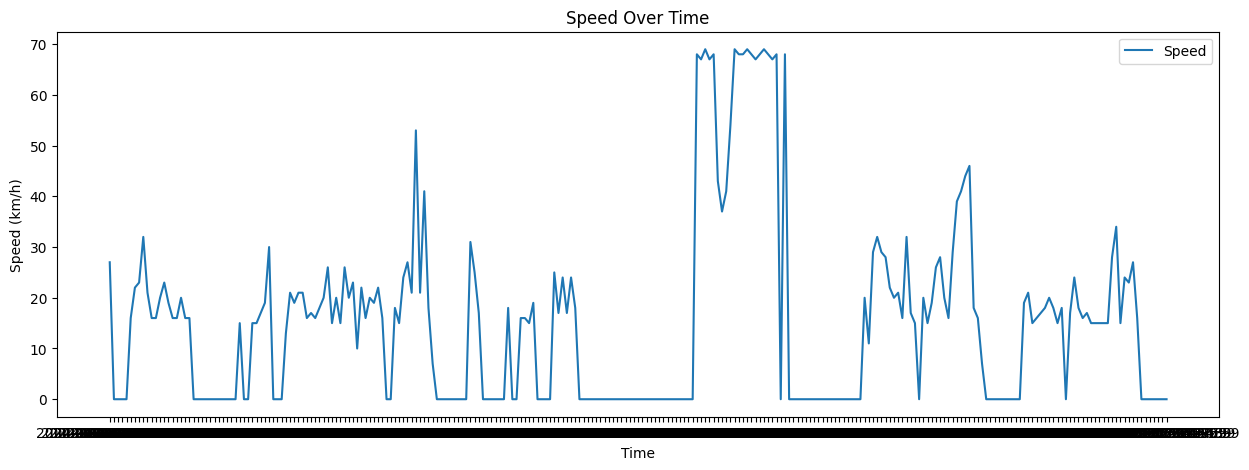

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['speed'], label='Speed')
plt.xlabel('Time')
plt.ylabel('Speed (km/h)')
plt.title('Speed Over Time')
plt.legend()
plt.show()

# Visualizing Speed on the Route (Colored by Speed)

In [13]:
import branca.colormap as cmz
import branca.colormap as cm
import matplotlib
norm = plt.Normalize(vmin=df['speed'].min(), vmax=df['speed'].max())

cmap = plt.cm.get_cmap('coolwarm')

colors = [cmap(norm(speed)) for speed in df['speed']]
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for i in range(len(route) - 1):
    segment = [route[i], route[i + 1]]
    folium.PolyLine(
        segment,
        color=matplotlib.colors.rgb2hex(colors[i]),
        weight=5,
        opacity=0.8
    ).add_to(m)


colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    index=[df['speed'].min(), df['speed'].max()],
    vmin=df['speed'].min(),
    vmax=df['speed'].max(),
    caption='Speed (km/h)'
)
colormap.add_to(m)

# Display the map
m.save('speed_route_map.html')


C:\Users\tousi.KCRND\AppData\Local\Temp\ipykernel_29400\2720897014.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


# Animating the Car's Movement

In [15]:
import plotly.express as px

fig = px.scatter_mapbox(
    df,
    lat='latitude',
    lon='longitude',
    color='speed',
    size='speed',
    size_max=15,
    zoom=10,
    mapbox_style='carto-positron',
    animation_frame=df['timestamp'],
    title='Car Movement Animation'
)

fig.show()

# Plotting Speed vs. Distance Traveled

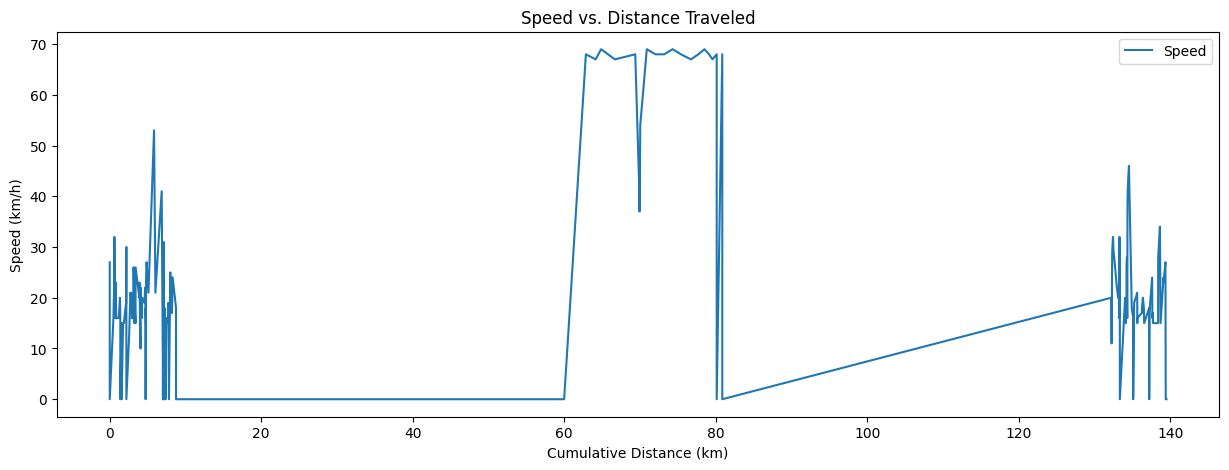

In [11]:
from geopy.distance import geodesic

distances = [0.0]
for i in range(1, len(df)):
    coords_1 = (df.loc[i - 1, 'latitude'], df.loc[i - 1, 'longitude'])
    coords_2 = (df.loc[i, 'latitude'], df.loc[i, 'longitude'])
    distance = geodesic(coords_1, coords_2).meters
    distances.append(distance)

df['distance_m'] = distances
df['cumulative_distance_km'] = df['distance_m'].cumsum() / 1000  # Convert to kilometers

plt.figure(figsize=(15, 5))
plt.plot(df['cumulative_distance_km'], df['speed'], label='Speed')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Speed (km/h)')
plt.title('Speed vs. Distance Traveled')
plt.legend()
plt.show()

## Heatmap of Speed

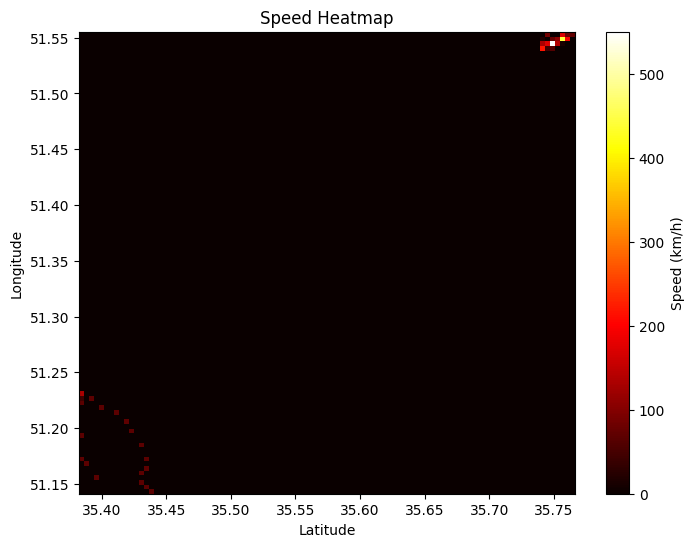

In [17]:
lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), 100)
lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), 100)

heatmap, xedges, yedges = np.histogram2d(
    df['latitude'], df['longitude'],
    bins=[lat_bins, lon_bins],
    weights=df['speed'],
)


plt.figure(figsize=(8, 6))
plt.imshow(
    heatmap.T,
    extent=[lat_bins[0], lat_bins[-1], lon_bins[0], lon_bins[-1]],
    origin='lower',
    cmap='hot',
    aspect='auto'
)
plt.colorbar(label='Speed (km/h)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Speed Heatmap')
plt.show()

# Interactive Route with Speed Popups
Add popups to the map that display speed when markers are clicked.

In [18]:
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=f"Speed: {row['speed']} km/h",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

m.save('route_with_speed_popups.html')

In [19]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=df['longitude'],
    y=df['latitude'],
    z=df['speed'],
    mode='lines',
    line=dict(color='blue', width=2),
    name='Speed'
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Speed (km/h)'
    ),
    title='3D Visualization of Speed Over Route'
)

fig.show()